In [11]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
df_test = pd.read_csv("./training_data/merged_train_i3.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model_try_6_i3")
model = BertForSequenceClassification.from_pretrained("saved_model_try_6_i3")

In [13]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)
    probabilities = probabilities.cpu()

    all_probabilities.append(probabilities) #Değiştir

In [14]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

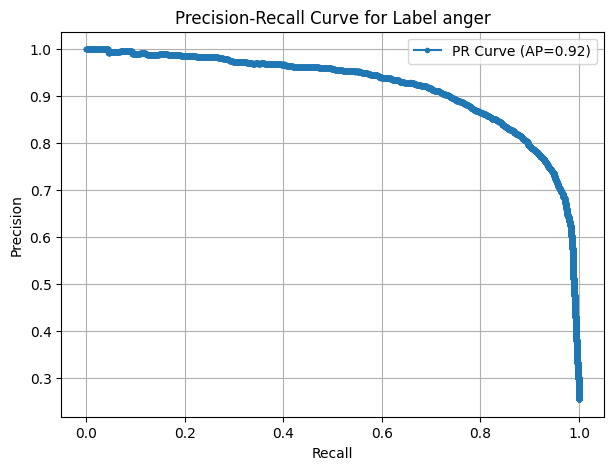

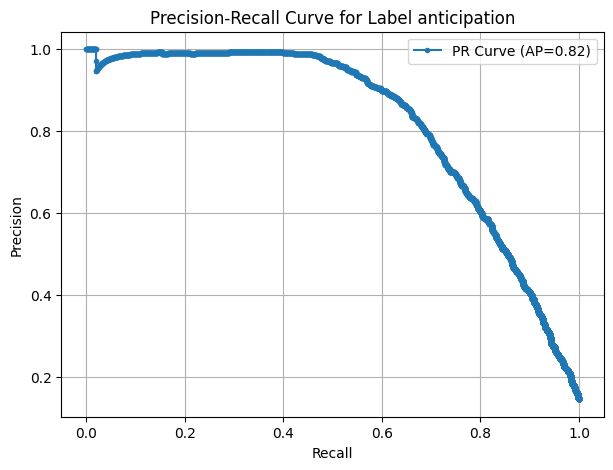

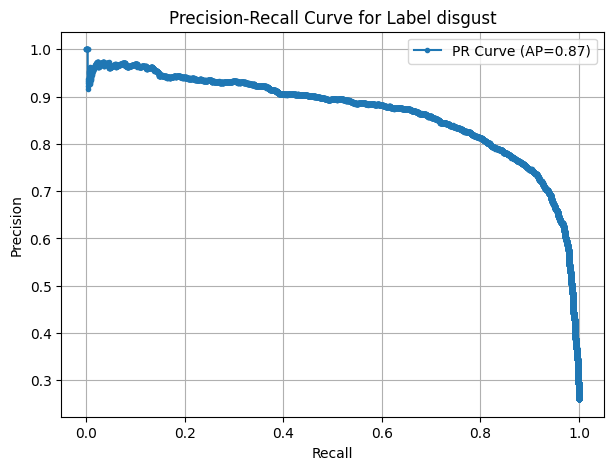

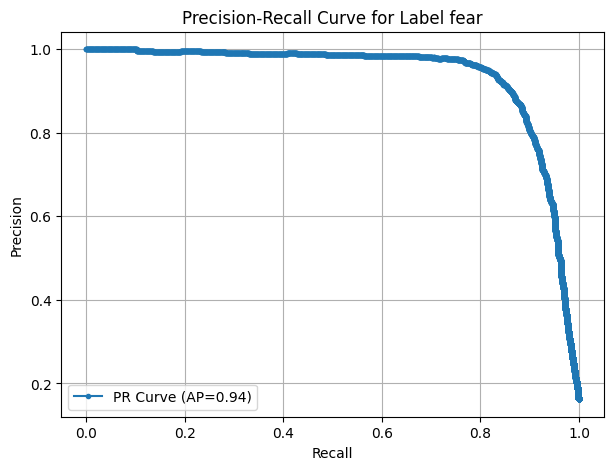

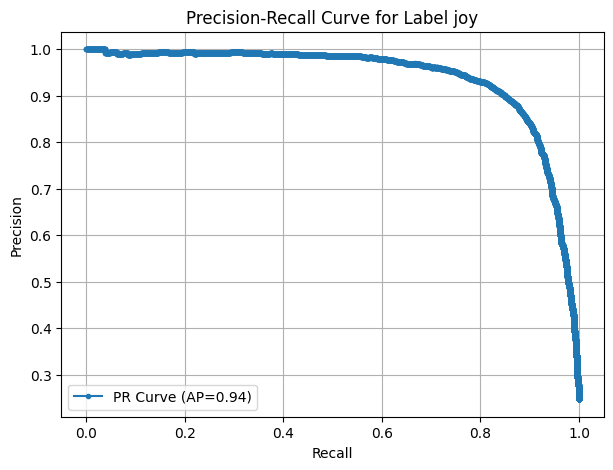

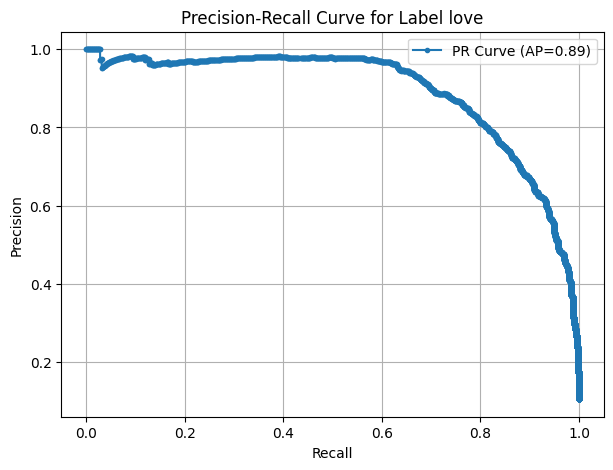

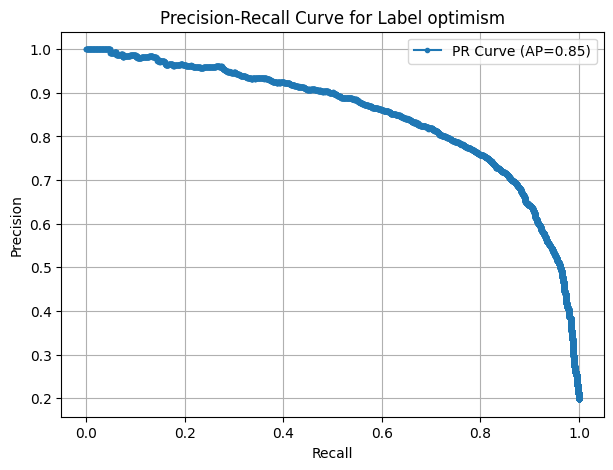

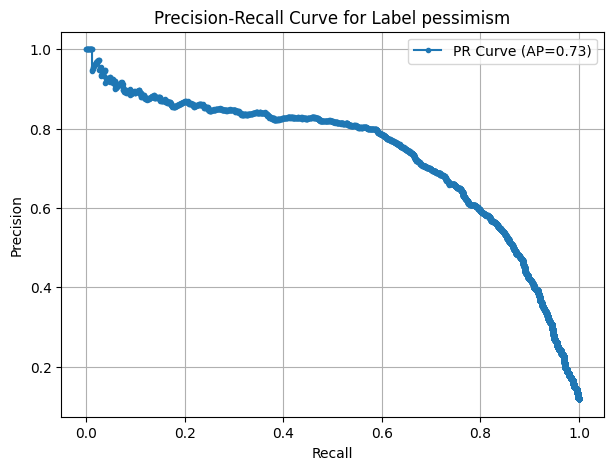

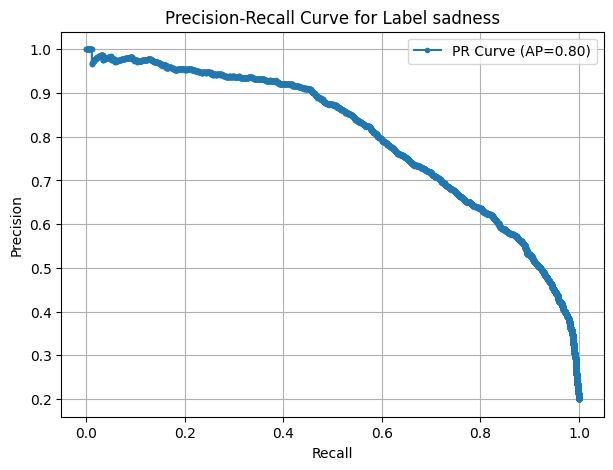

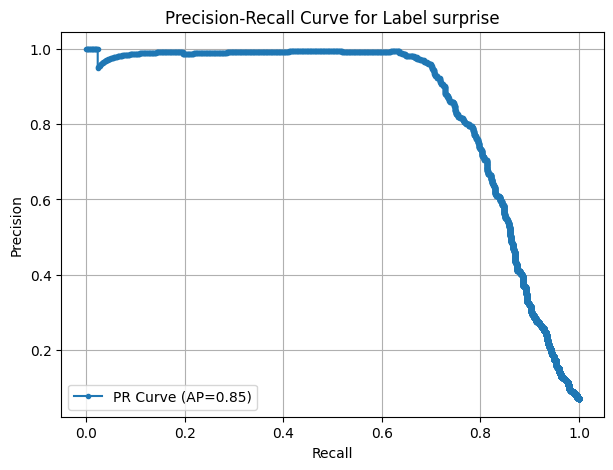

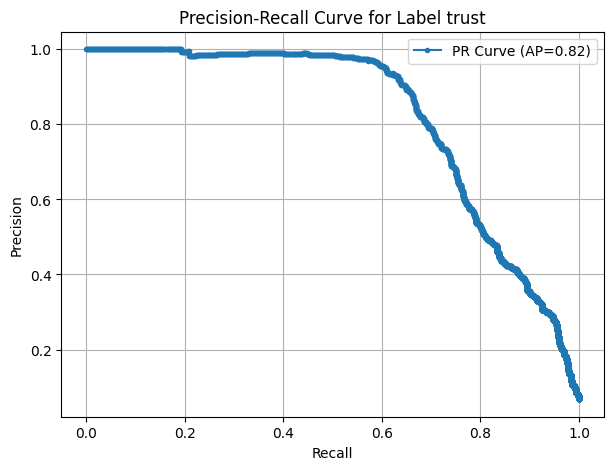

[0.43, 0.39, 0.37, 0.55, 0.4, 0.56, 0.42, 0.46, 0.44, 0.54, 0.62]


,0,1,2,3,4,5,6,7,8,9,10
0,0.038669,0.180948,0.027177,0.313513,0.546366,0.091057,0.948070,0.059316,0.083734,0.035915,0.698811
1,0.034967,0.107482,0.025055,0.029329,0.905139,0.564114,0.916501,0.033671,0.045513,0.048252,0.336502
2,0.312291,0.224389,0.321212,0.059608,0.740889,0.046602,0.228142,0.068117,0.228369,0.767148,0.068988
3,0.039491,0.161128,0.032552,0.052984,0.949496,0.352047,0.949548,0.035817,0.065661,0.081904,0.412925
4,0.917371,0.050318,0.918866,0.210560,0.039286,0.016043,0.027776,0.096544,0.440114,0.032886,0.017676
...,...,...,...,...,...,...,...,...,...,...,...
11667,0.036752,0.094835,0.036113,0.013695,0.877660,0.193052,0.268977,0.016114,0.025501,0.073873,0.059536
11668,0.022464,0.875639,0.023104,0.045934,0.046904,0.029367,0.080845,0.050779,0.021588,0.054795,0.064424
11669,0.692803,0.093275,0.469216,0.051879,0.026349,0.008556,0.086615,0.025829,0.054931,0.016788,0.049330
11670,0.053536,0.081128,0.045576,0.055812,0.076606,0.859189,0.069829,0.065119,0.037791,0.070171,0.077480


In [15]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd